# World Data Viz Challenge 2020 - Barcelona
This is the Jupyter Notebook of the project presented in World Data Viz Challange 2020

## Contents
1. Importing Available Datasets
0. Graph Data Visualization
0. Training the model
0. Evaluating the model

## 1. Importing Available Datasets

In this section the datasets used to train the proposed architecture are detailed and loaded into the `dataset` variable.

The type of dataset supported by this architecture has to be of the form of:

| Codi_Districte        | Codi_Barri     | Expected output   |
|-----------------------|----------------|-------------------|
|`int`                  |`int`           |`float`            |

The tested dataset reported in this work are shown below: uncomment the desired dataset for the model training of the specific task.


In [1]:
import datasets

# LLOGUERS DATASET: params (default):
#   - years: list of available years to take the dataset from
#   - lloguer_mensual (False): boolean variable to predict monthly value or m2
#dataset = datasets.LloguersDataset(years=[2019,2018,2017], lloguer_mensual=True)
dataset = datasets.LloguersDataset(years=[2019,2018,2017], lloguer_mensual=False)

# ATURS DATASET: params:
#   - years: list of available years to take the dataset from
#   - specific_months ([1, ..., 12]): Months in which the dataset will take values from (e.g. prediction only January: [1])
#dataset = datasets.AtursDataset(years=[2019, 2018])
#dataset = datasets.AtursDataset(years=[2019, 2018], specific_months=[6,7,8])

# ESPERANÇA DE VIDA DATASET: no params:
#dataset = datasets.EspVidaDataset()

# SUPERFÍFICE HABITATGE: params:
#   - years: list of available years to take the dataset from
#dataset = datasets.SuperficieHabitatge(years=[2019, 2018])

# SUPERFICIE DE LLOGUER: params:
#   - years: list of available years to take the dataset from
#dataset = datasets.SuperficieLloguer(years=[2019,2018,2017,2016])

# RENDA TRIBUTARIA: params
#   - years: list of available years to take the dataset from
#dataset = datasets.RendaTributaria(years=[2017])

# EDAT MITJANA: params
#   - years: list of available years to take the dataset from
#dataset = datasets.EdatMitjana(years=[2019, 2018])

data_name = dataset.get_title()
print("Dataset Loaded: {0}".format(data_name))

Dataset Loaded: Precio Alquiler (€/m2)


## 2. Graph Data Visualization
The input of the proposed architecture are two graphs which encodes the the topological information of the city's districts and neighbrhoods in the form of an adjacency matrix.

Each neighborhood and district has it's own weighted graph in which the connections are stronger if the neighborhood/district are side by side in the city map.

A nice way to view the adjacency matrix is by treating it as an image where each pixel color determines a weight-connexion:
- __Yellow__: The connection between the neighborhood/district and itself (always in the diagonal of the matrix)
- __Green__: The weighted connection between the neighborhood/district and it's adjacent neighborhood/district according to the city distribution
- __Blue__: The real connections between neighborhoods/districts
- __Dark Blue__: No connection between these neighborhoods/districts.

Each district graph is a $10 \times 10$ matrix and the neighborhood graph is a $73 \times 73$ matrix.

To iterate between all possible inputs change the varialbe `dataset_sample` between 1 and 73 (representing all the neighborhood - districts will update according)


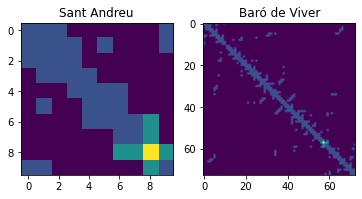

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import datasets

BCN_dataset = datasets.BCNDataset()

# Data sample from 1 to 73
dataset_sample = 58

sample = BCN_dataset[dataset_sample-1]
neighborhood_graph = sample['neighborhood_graph']
district_graph = sample['district_graph']

f, axarr = plt.subplots(1,2) 
axarr[0].imshow(district_graph)
axarr[0].title.set_text(sample['district_name'])
axarr[1].imshow(neighborhood_graph)
axarr[1].title.set_text(sample['neighborhood_name'])

## 3. Training the model
The training of the Graph Neural Network is done through the `train_model` method. This function returns the trained model as well as the loss values at each epoch of the iteration (both from training and validation).

The method requires to sepcify the training dataset, number of epochs, batch size and the learning rate.

In our implementation, the hyper parameter choice (which can be fine tunded in `train.py`) follows:
- __Optimizer__: ADAM
- __Loss function__: Mean Squared Error MSE
- __Learning rate__: 0.0005
- __Split dataset__: 70% train, 30% Validation


In [3]:
from train import train_model

# Function to train the model, returns the model and loss values
model, loss_train, loss_val = train_model(dataset, num_epochs=150, batch_size=200, lr=0.0005)

Epoch [  0/150] 	 Training Loss: 505.4498 	 Validation Loss: 158.7169
Epoch [ 10/150] 	 Training Loss: 12.3312 	 Validation Loss: 3.3716
Epoch [ 20/150] 	 Training Loss: 6.4399 	 Validation Loss: 2.5962
Epoch [ 30/150] 	 Training Loss: 5.7226 	 Validation Loss: 2.2906
Epoch [ 40/150] 	 Training Loss: 5.1733 	 Validation Loss: 2.1145
Epoch [ 50/150] 	 Training Loss: 4.7602 	 Validation Loss: 2.0645
Epoch [ 60/150] 	 Training Loss: 4.5246 	 Validation Loss: 1.9575
Epoch [ 70/150] 	 Training Loss: 4.1247 	 Validation Loss: 1.9246
Epoch [ 80/150] 	 Training Loss: 3.7371 	 Validation Loss: 1.8715
Epoch [ 90/150] 	 Training Loss: 2.9663 	 Validation Loss: 2.0538
Epoch [100/150] 	 Training Loss: 2.7854 	 Validation Loss: 1.9290
Epoch [110/150] 	 Training Loss: 2.4522 	 Validation Loss: 1.8324
Epoch [120/150] 	 Training Loss: 2.3441 	 Validation Loss: 1.7910
Epoch [130/150] 	 Training Loss: 2.2394 	 Validation Loss: 1.6456
Epoch [140/150] 	 Training Loss: 2.2919 	 Validation Loss: 1.7225


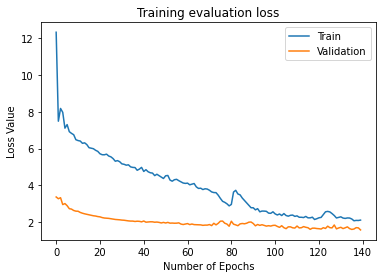

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Visualization of the loss value evolution (discarding the firts epochs - random init)
plt.plot(loss_train[10:], label="Train")
plt.plot(loss_val[10:], label="Validation")

plt.xlabel("Number of Epochs")
plt.ylabel("Loss Value")
plt.legend(loc="upper right")
plt.title("Training evaluation loss")

# Save the figure
#plt.savefig("output/loss_.png")

plt.show()

## 4. Evaluate the model
The function `evaluate_model` generates a new dataset where there are as many entries as neighborhoods. It generates both the district and neighborhood graph and evaluates each entry.

Results are shown in form of a print table and a temperature map

In [5]:
from train import evaluate_model

evaluations = evaluate_model(model)
predictions = []

for evaluation in evaluations:
    print("Districte: {0:<25s}Barri: {1:<50s}{2:>20s}: {3:.2f}".format(
    evaluation['district_name'],
    evaluation['neighborhood_name'],
    data_name,
    evaluation['prediction']) )

    predictions.append(evaluation['prediction'])

Districte: Ciutat Vella             Barri: el Raval                                          Precio Alquiler (€/m2): 14.57
Districte: Ciutat Vella             Barri: el Barri Gòtic                                    Precio Alquiler (€/m2): 14.57
Districte: Ciutat Vella             Barri: la Barceloneta                                    Precio Alquiler (€/m2): 14.57
Districte: Ciutat Vella             Barri: Sant Pere, Santa Caterina i la Ribera             Precio Alquiler (€/m2): 14.57
Districte: Eixample                 Barri: el Fort Pienc                                     Precio Alquiler (€/m2): 13.62
Districte: Eixample                 Barri: la Sagrada Família                                Precio Alquiler (€/m2): 13.59
Districte: Eixample                 Barri: la Dreta de l'Eixample                            Precio Alquiler (€/m2): 13.59
Districte: Eixample                 Barri: l'Antiga Esquerra de l'Eixample                   Precio Alquiler (€/m2): 13.66
Districte: Eixam

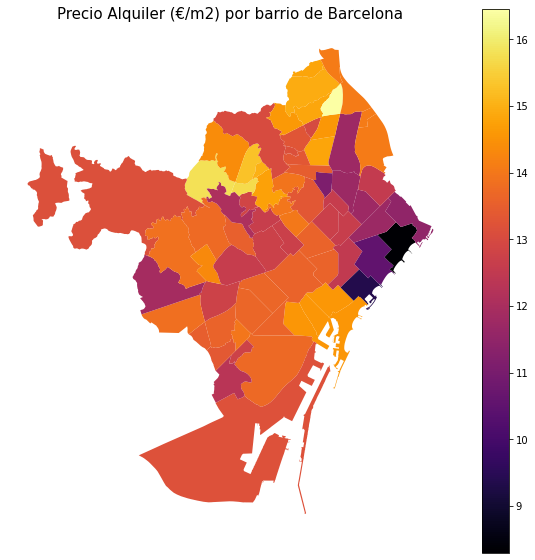

In [6]:
import geopandas as gpd

# Load the district map GEOJSON and add the column predicition
map_data = gpd.read_file("bcn_map/barris.geojson")
map_data['PRED'] = predictions
fig, ax = plt.subplots(figsize=(10, 10))
 
# Axis names and titles 
ax.set_title(data_name + " por barrio de Barcelona", fontdict={'fontsize': 15})
#ax.set_xlabel('Longitud')
#ax.set_ylabel('Latitud')
plt.axis('off')

map_data.plot(column='PRED', cmap='inferno', ax=ax, zorder=10, legend=True)
#plt.savefig("output/heatmap_.png")
